In [2]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch import Tensor
import functools
import os
import numpy as np

import warnings
import glob


import io
from joblib import delayed 

from cacher import root, file_cached, mem_cached, clear_cache

import pymorphy2

from corus import load_lenta2
from navec import Navec
from razdel import tokenize, sentenize

from utils import ProgressParallel
from joblib import delayed

from utils import download_file

from slovnet.model.emb import NavecEmbedding

# from torchmetrics.functional.classification import binary_accuracy

import random
import string


from pymorphy2.tagset import OpencorporaTag
from params import NO_PUNCT, build_params

# https://pymorphy2.readthedocs.io/en/stable/user/grammemes.html
# http://opencorpora.org/dict.php?act=gram
# https://github.com/pymorphy2/pymorphy2/blob/92d546f042ff14601376d3646242908d5ab786c1/pymorphy2/tagset.py#L130
feature_tags_array = [
    OpencorporaTag.PARTS_OF_SPEECH, # часть речи
    OpencorporaTag.GENDERS, # род
    OpencorporaTag.NUMBERS, # число
    OpencorporaTag.CASES, # падеж
    OpencorporaTag.ASPECTS, # соверш / несоверш
    OpencorporaTag.TRANSITIVITY, # перех / непереходный
    OpencorporaTag.PERSONS, # лицо
    OpencorporaTag.TENSES, # время
    OpencorporaTag.MOODS, # наклонение
    OpencorporaTag.VOICES, # залог
    #INVOLVEMENT
    ['Prnt'], # вводные слова
    ['Apro'], # местоимение
    ['NUMB'], # число вида 1234
    ['LATIN'], # текст на английском
    ['UNKN'], # неизвестный токен
]


params = build_params({
    "VARIANTS_CNT": 2,
    "TARGET_CLASSES_COUNT": 3,
    "INPUT_WORDS_CNT": 5,
    "feature_tags_array": feature_tags_array,
    "PUNCTUATION_TARGET": {
        "$empty": NO_PUNCT,
        ".": 1,
        "!": 1,
        "?": 1,
        ",": 2,
    },
    "USE_NAVEC_EMBEDDING": True
})
torch.cuda.is_available(), torch.rand(10).to('cuda:0')

(True,
 tensor([0.6871, 0.3796, 0.1701, 0.3760, 0.7182, 0.7068, 0.8132, 0.5319, 0.5554,
         0.8180], device='cuda:0'))

In [13]:
from navec import Navec
navec_path = download_file('hudlit_12B_500K_300d_100q.tar',
        "https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar")
navec = Navec.load(navec_path)
navec['кек'].shape

(300,)

In [7]:

# input, output = create_dataset([
#     'Однако самые ранние свидетельства приручения кошек древними египтянами относились к 2000—1900 годам до нашей эры. А недавно было установлено, что в Древний Египет домашняя кошка попала, как и на Кипр, с территории Анатолии. В настоящее время кошка является одним из самых популярных домашних животных. ',
#     'В лесу родилась елочка, в лесу она росла.'])
# input.shape, output.shape
import dataset_builder 
import importlib
importlib.reload(dataset_builder) 
lenta_path = download_file("lenta-ru-news.csv.gz", 
    "https://github.com/yutkin/Lenta.Ru-News-Dataset/releases/download/v1.1/lenta-ru-news.csv.bz2")

@mem_cached("read_lenta_records")
def read_lenta_records(cnt):
    records = load_lenta2(lenta_path)
    res = []
    for record in records:
        if len(res) >= cnt: break
        res.append(record.text)
    return res

@mem_cached("create_lenta_dataset")
@file_cached("create_lenta_dataset")
def create_lenta_dataset(cnt, params):
    texts = read_lenta_records(cnt)
    input, output = dataset_builder.create_dataset(texts, params)
    return {"input": input, "output": output}

dataset = create_lenta_dataset(50000, params)
input, output = dataset['input'], dataset['output']
input.shape, output.shape, 



  0%|          | 0/50000 [00:00<?, ?it/s]

(torch.Size([1671812, 5, 2, 54]), torch.Size([1671812, 3]))

In [8]:
def size_of_tensor(tensor):
    return str(round(tensor.nelement() * tensor.element_size() / 1024 / 1024 )) + " Mb"
def count_parameters(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    return param_size / 1024 ** 2
size_of_tensor(input), size_of_tensor(output), torch.sum(output, 0) / len(output)

('3444 Mb', '19 Mb', tensor([0.3946, 0.2553, 0.3501]))

In [83]:
# a = nn.Conv2d(N, 32, 
#               kernel_size=FEATURES_CNT, 
#                     stride=FEATURES_CNT) # convolve each word into 32-vector-embedding
a = nn.Flatten(1)
input.shape, a(input).shape

(torch.Size([1671211, 5, 2, 60]), torch.Size([1671211, 600]))

In [9]:
from xformers.factory import xFormerEncoderBlock, xFormerEncoderConfig
N_words = params["INPUT_WORDS_CNT"]
N_variants = params["VARIANTS_CNT"]
N_features = params["FEATURES_CNT"]

INTERNAL_EMBEDDING_SIZE = 16

encoder_config = {
    "dim_model": INTERNAL_EMBEDDING_SIZE, #N_variants * N_features,
    "residual_norm_style": "pre",  # Optional, pre/post
    "position_encoding_config": {
        "name": "sine",  # whatever position encodinhg makes sense
        # "dim_model": VARIANTS_CNT * N_features,
    },
    "multi_head_config": {
        "num_heads": 4,
        "residual_dropout": 0,
        "attention": {
            "name": "linformer", #m scaled_dot_productfourier_mix, "linformer" scaled_dot_product,  # whatever attention mechanism
            "dropout": 0, # linformer
            "seq_len": N_words, # linformer, scaled_dot_product
            "to_seq_len": N_words, # scaled_dot_product
        },
    },
    "feedforward_config": {
        "name": "MLP",
        "dropout": 0,
        "activation": "relu",
        "hidden_layer_multiplier": 1,
    },
}

A matching Triton is not available, some optimizations will not be enabled.
Error caught was: No module named 'triton'
Triton is not available, some optimizations will not be enabled.
This is just a warning: No module named 'triton'
Triton is not available, FusedMLP will not be enabled.
Either FairScale or torch distributed is not available, MixtureOfExperts will not be exposed. Please install them if you would like to use MoE


0.021 Mb of parameters
[0/400] [17.3 s]	 loss: 0.7668 loss_test: 0.6488  lr: 0.0010  
[1/400] [21.5 s]	 loss: 0.6200 loss_test: 0.6037  lr: 0.0010  
[2/400] [25.8 s]	 loss: 0.5931 loss_test: 0.5843  lr: 0.0010  
[3/400] [30.1 s]	 loss: 0.5794 loss_test: 0.5735  lr: 0.0010  
[4/400] [34.4 s]	 loss: 0.5703 loss_test: 0.5664  lr: 0.0010  
interrupted


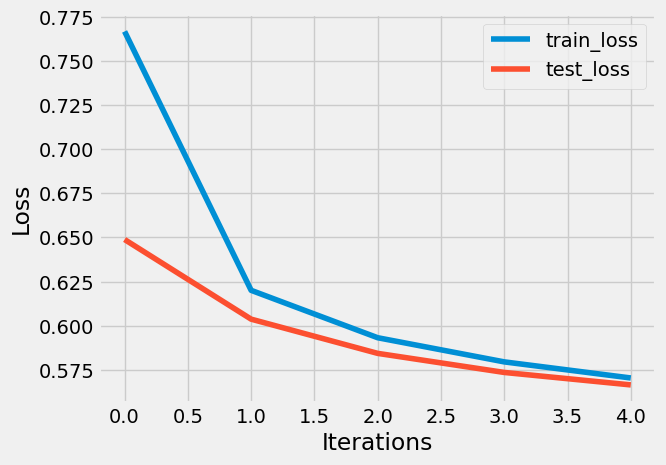

In [10]:
class Model(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        N_words = params['INPUT_WORDS_CNT']
        N_variants = params['VARIANTS_CNT']
        N_features = params['FEATURES_CNT']

        # input is (N, N_words, N_variants, N_features)
        # output is (N, N_words, )

        self.model = nn.Sequential(
            nn.Flatten(2), # (N, N_words, N_variants *N_features)
            # nn.TransformerEncoder(encoder_layer, num_layers=1),encoder = 
            nn.Linear(N_variants * N_features, INTERNAL_EMBEDDING_SIZE),
            
            xFormerEncoderBlock(xFormerEncoderConfig(**encoder_config)),
            xFormerEncoderBlock(xFormerEncoderConfig(**encoder_config)),

            nn.Flatten(1), # (N, N_words* INTERNAL_EMBEDDING_SIZE)
            # nn.Tanh(),
            nn.Linear(N_words* INTERNAL_EMBEDDING_SIZE, params['TARGET_CLASSES_COUNT']),
            # nn.ReLU(),
            # nn.Linear(100, TARGET_CLASSES_COUNT),
            # nn.Tanh(),
            # nn.Tanhshrink(),
            # nn.Sigmoid(),
            # nn.ReLU(),
        )


    def forward(self, x):
        return self.model(x)

    # buffer_size = 0
    # for buffer in model.buffers():
    #     buffer_size += buffer.nelement() * buffer.element_size()
    # return (param_size + buffer_size) / 1024**2


aa = {}
def train_model():
    model = Model()
    print(round(count_parameters(model), 3), "Mb of parameters")
    import importlib
    import trainer_mod
    importlib.reload(trainer_mod)
    Trainer = trainer_mod.Trainer

    optimizer = torch.optim.Adam(model.parameters(), 
                            lr=1e-3)
                            # betas=(0.5, 0.999))

    trainer = Trainer(model=model, 
                    # loss=nn.MSELoss(),
                    loss=nn.CrossEntropyLoss(),
                    optimizer=optimizer,
                    scheduler=None,
                    # scheduler=ReduceLROnPlateau(optimizer, factor=0.2, threshold=1e-5, patience=50),
                    additional_losses={
                        # "accurancy": lambda trainer: {"accurancy": 
                        #    float(torch.mean(torch.abs(trainer.model(trainer.x_test) - trainer.y_test)).detach())
                        # },
                    })

    trainer.set_data(input, output, train_test_split=0.9)
    try:
        trainer.train(400, batch=4000, trial=None, log=True)
    except KeyboardInterrupt:
        print("interrupted")
        # type, val, tb = sys.exc_info()
        # traceback.clear_frames(tb)
        pass
    
    trainer.plot_history(cutoff=0)
    return trainer
import os
# os.environ["CUDA_HOME"] = "/home/misha-sh/cuda"

trainer = train_model()
# run_proc(train_model)

wer


<module '__main__'>

In [45]:
import __main__

for i in ["_", "__", "___", "____", "_____", "trainer", "model", "optimizer", "Out"] + \
         ["_" + str(j) for j in range(100)]:
    for j in [locals(), globals(), __main__.__dict__]:
        try:
            del j[i]
        except: pass
        for f in range(100):
            try:
                del j["_oh"][f]
            except:
                pass
import sys
try:
    sys.last_traceback.tb_next = None
except: pass

import objgraph
for i in objgraph.by_type('Trainer'):
    i.model = None
    i.x = None
    i.y = None
    i.optimizer = None
    i.x_train = None
    i.y_train = None
    i.x_test = None
    i.y_test = None
    
import gc
aa.clear()
gc.collect()
torch.cuda.empty_cache() 
1/0


# import sys,functools, traceback
# def gpu_mem_restore(func):
#     "Reclaim GPU RAM if CUDA out of memory happened, or execution was interrupted"
#     @functools.wraps(func)
#     def wrapper(*args, **kwargs):
#         try:
#             return func(*args, **kwargs)
#         except:
#             type, val, tb = sys.exc_info()
#             traceback.clear_frames(tb)
#             raise type(val).with_traceback(tb) from None
#     return wrapper

# @gpu_mem_restore

ZeroDivisionError: division by zero

In [ ]:
# chain[1] asdf
for elem in chain[1]:
    # if "trainer_mod.Trainer" in str(chain[1][elem]) and not isinstance(chain[1][elem], str)
    if chain[2] == chain[1][elem]:
        print(elem)

for elem in chain[2]:
    if "trainer_mod.Trainer" in str(chain[2][elem]) and not isinstance(chain[2][elem], str)
    # if chain[3] == chain[2][elem]:
        print(elem)

import torch.nn as nn
import torch
def ttest():
    model = nn.Linear(100 * 100, 1).to("cuda:0")
    try:
        for i in range(1000000000):
            pass
    except KeyboardInterrupt:
        print("wer")
        pass
    a = torch.rand(100).to('cuda:0')
    return model
model = ttest()

_oh


In [ ]:
inp = nn.Flatten(2)(input[:11])

config = xFormerEncoderConfig(**encoder_config)

encoder = xFormerEncoderBlock(config)

#  Test out with dummy inputs
x = (torch.rand((10, N_words, N_variants * N_features))).abs().to(torch.float32)
y = encoder(x) # (x, x, x)
print(x.shape, y.shape)

# a = nn.TransformerEncoderLayer(d_model=N_variants *N_features,
#                                nhead=4, dim_feedforward=10, batch_first=True)
# inp.shape, a(inp).shape, count_parameters(a)

In [ ]:
aa

{}

In [ ]:
%reset_selective trainer

In [ ]:

objgraph.find_backref_chain(objgraph.by_type('Trainer')[0], objgraph.is_proper_module)[-2]

SyntaxError: cannot delete function call (3434817761.py, line 2)

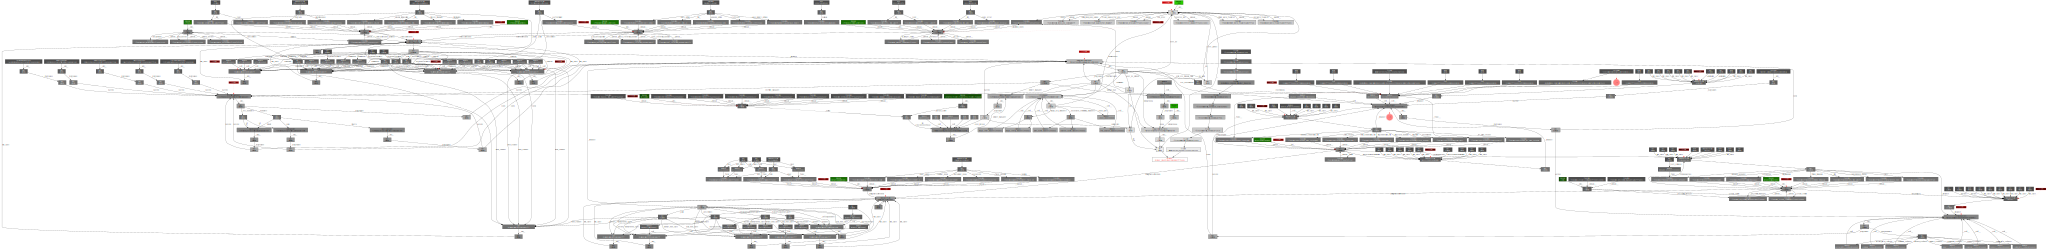

In [ ]:
import objgraph
objgraph.show_backrefs(objgraph.by_type('Trainer'), 10)

In [ ]:
from xformers.factory import xFormerEncoderBlock, xFormerEncoderConfig
N_words = INPUT_WORDS_CNT
N_variants = VARIANTS_CNT
N_features = FEATURES_CNT

INTERNAL_EMBEDDING_SIZE = 4

encoder_config = {
    "dim_model": INTERNAL_EMBEDDING_SIZE, #N_variants * N_features,
    "residual_norm_style": "pre",  # Optional, pre/post
    "position_encoding_config": {
        "name": "sine",  # whatever position encodinhg makes sense
        # "dim_model": VARIANTS_CNT * N_features,
    },
    "multi_head_config": {
        "num_heads": 4,
        "residual_dropout": 0,
        "attention": {
            "name": "scaled_dot_product", #m fourier_mix, "linformer" scaled_dot_product,  # whatever attention mechanism
            "dropout": 0, # linformer
            "seq_len": N_words, # linformer, scaled_dot_product
            "to_seq_len": N_words, # scaled_dot_product
        },
    },
    "feedforward_config": {
        "name": "MLP",
        "dropout": 0,
        "activation": "relu",
        "hidden_layer_multiplier": 1,
    },
}
# print(INTERNAL_EMBEDDING_SIZE,
#         round(count_parameters(nn.Linear(N_variants * N_features, INTERNAL_EMBEDDING_SIZE)), 4),
#         round(count_parameters(xFormerEncoderBlock(xFormerEncoderConfig(**encoder_config))), 4), "x2 ",
#         round(count_parameters(nn.Linear(N_words* INTERNAL_EMBEDDING_SIZE, TARGET_CLASSES_COUNT)), 4),
#         "=",
#         round(count_parameters(Model()), 4))


In [ ]:
y_test, y_pred

(array([0, 2, 2, ..., 2, 0, 0]), array([0, 2, 2, ..., 1, 0, 0]))

<AxesSubplot: >

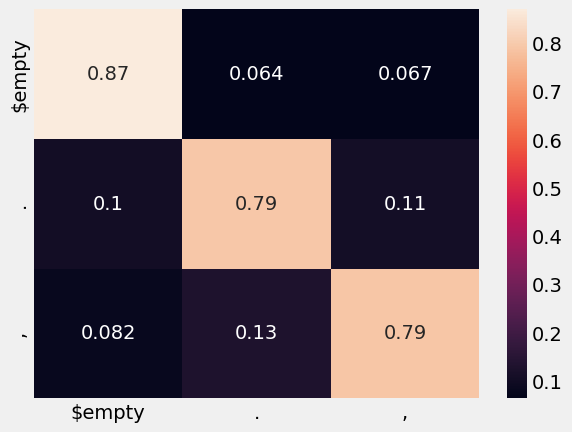

In [ ]:
with torch.no_grad():
    trainer.model.eval()
    y_test_pred = trainer.model(trainer.x_test)
    _, y_pred_tags = torch.max(y_test_pred, dim = 1)
    y_pred = y_pred_tags.cpu().numpy()
    _, y_test_tags = torch.max(trainer.y_test, dim = 1)
    y_test = y_test_tags.cpu().numpy()
    
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred, normalize="true")).rename(
        columns=ID_TO_PUNCTUATION, index=ID_TO_PUNCTUATION)
sns.heatmap(confusion_matrix_df, annot=True)

In [ ]:
with torch.no_grad():
    model.eval()
    model.to

In [ ]:
y_test.shape, y_pred_list.shape

((167122, 3), (1, 167122))

In [ ]:
trainer.y_train

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 2.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0.])

In [ ]:
# scaler = GradScaler()

# for input, target in data:
#     with torch.autocast(device_type='cuda'):
#         output = model(input)
#         loss = loss_fn(output, target)
#     scaler.scale(loss).backward()
#     scaler.step(optimizer)
#     scaler.update()
